In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## create column subset

In [27]:
ddf = dd.read_parquet('03_xenophobia/ESS/data/parquet')
ddf.head()

,name,essround,edition,proddate,cntry,idno,tvtot,tvpol,rdtot,rdpol,...,sofrpr,sofrprv,ppldsrv,jstprev,pcmpinj,domain,prob,stratum,psu,year
0,ESS1e06_6,1.0,6.6,01.12.2018,AT,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
1,ESS1e06_6,1.0,6.6,01.12.2018,AT,2.0,3.0,2.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
2,ESS1e06_6,1.0,6.6,01.12.2018,AT,3.0,7.0,3.0,0.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
3,ESS1e06_6,1.0,6.6,01.12.2018,AT,4.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002
4,ESS1e06_6,1.0,6.6,01.12.2018,AT,6.0,0.0,66.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002


In [28]:
len(ddf)

430870

In [29]:
ddf.year.value_counts(normalize=True, sort=False).compute() * 100

2002     9.831040
2004    11.032794
2006     9.979808
2008    13.171490
2010    12.174902
2012    12.688978
2014     9.326479
2016    10.301715
2018    11.492794
Name: year, dtype: float64

In [30]:
demographicsCols = [
    'cntry',    # country
    'idno',     # id number of individual
    'year', 
    'anctry1',  # primary ancestry
    'anctry2',  # secondary ancestry
    'region'    # region (that they live in currently?)
    ]
immiCols = [
    'imsmetn',  # Allow many/few immigrants of same race/ethnic group as majority
    'imdfetn',  # Allow many/few immigrants of different race/ethnic group from majority  
    'impcntr',  # Allow many/few immigrants from poorer countries outside Europe
    'imbgeco',  # Immigration bad or good for country's economy 
    'imueclt',  # Country's cultural life undermined or enriched by immigrants
    'imwbcnt',  # Immigrants make country worse or better place to live
    ]

subset = ddf[immiCols + demographicsCols]
subset.head()

,imsmetn,imdfetn,impcntr,imbgeco,imueclt,imwbcnt,cntry,idno,year,anctry1,anctry2,region
0,4.0,3.0,3.0,4.0,9.0,7.0,AT,1.0,2002,NaN,NaN,None
1,2.0,2.0,2.0,10.0,10.0,5.0,AT,2.0,2002,NaN,NaN,None
2,3.0,3.0,3.0,7.0,5.0,5.0,AT,3.0,2002,NaN,NaN,None
3,1.0,2.0,1.0,10.0,10.0,10.0,AT,4.0,2002,NaN,NaN,None
4,8.0,8.0,8.0,88.0,88.0,88.0,AT,6.0,2002,NaN,NaN,None


In [31]:
len(subset)

430870

In [32]:
subset.dtypes

imsmetn    float64
imdfetn    float64
impcntr    float64
imbgeco    float64
imueclt    float64
imwbcnt    float64
cntry       object
idno       float64
year         int64
anctry1    float64
anctry2    float64
region      object
dtype: object

In [86]:
subset.to_csv('03_xenophobia/ESS/data/columnSubset.csv', single_file=True)

['c:\\Users\\astro\\Dropbox\\glovo\\aux_data\\03_xenophobia\\ESS\\columnSubset.csv']

## start with column subset

In [92]:
df = pd.read_csv('03_xenophobia/ESS/data/columnSubset.csv', index_col=0, low_memory=False)
df.head()

,imsmetn,imdfetn,impcntr,imbgeco,imueclt,imwbcnt,cntry,idno,year,anctry1,anctry2,region
0,4.0,3.0,3.0,4.0,9.0,7.0,AT,1.0,2002,NaN,NaN,NaN
1,2.0,2.0,2.0,10.0,10.0,5.0,AT,2.0,2002,NaN,NaN,NaN
2,3.0,3.0,3.0,7.0,5.0,5.0,AT,3.0,2002,NaN,NaN,NaN
3,1.0,2.0,1.0,10.0,10.0,10.0,AT,4.0,2002,NaN,NaN,NaN
4,8.0,8.0,8.0,88.0,88.0,88.0,AT,6.0,2002,NaN,NaN,NaN


In [93]:
len(df)

430870

### decode region and ethnicity

In [94]:
with open('03_xenophobia/ESS/regions.csv') as f:
    regionLookup = {line.split(', ')[0]: line.split(', ')[1].strip() for line in f.readlines()}
regionLookup

{'AT11': 'Burgenland',
 'AT12': 'Niederösterreich',
 'AT13': 'Wien',
 'AT21': 'Kärnten',
 'AT22': 'Steiermark',
 'AT31': 'Oberösterreich',
 'AT32': 'Salzburg',
 'AT33': 'Tirol',
 'AT34': 'Vorarlberg',
 'BE10': 'Région de Bruxelles-Capitale /Brussels Hoofdstedelijk Gewest',
 'BE21': 'Prov. Antwerpen',
 'BE22': 'Prov. Limburg',
 'BE23': 'Prov. Oost-Vlaanderen',
 'BE24': 'Prov. Vlaams-Brabant',
 'BE25': 'Prov. West-Vlaanderen',
 'BE31': 'Prov. Brabant Wallon',
 'BE32': 'Prov. Hainaut',
 'BE33': 'Prov. Liège',
 'BE34': 'Prov. Luxembourg',
 'BE35': 'Prov. Namur',
 'BG311': 'Vidin',
 'BG312': 'Montana',
 'BG313': 'Vratsa',
 'BG314': 'Pleven',
 'BG315': 'Lovech',
 'BG321': 'Veliko Tarnovo',
 'BG322': 'Gabrovo',
 'BG323': 'Ruse',
 'BG324': 'Razgrad',
 'BG325': 'Silistra',
 'BG331': 'Varna',
 'BG332': 'Dobrich',
 'BG333': 'Shumen',
 'BG334': 'Targovishte',
 'BG341': 'Burgas',
 'BG342': 'Sliven',
 'BG343': 'Yambol',
 'BG344': 'Stara Zagora',
 'BG411': 'Sofia (capital)',
 'BG412': 'Sofia (region)

In [95]:
with open('03_xenophobia/ESS/ethnicities.csv') as f:
    ethnicityLookup = {float(line.split(', ')[0]): line.split(', ')[1].strip() for line in f.readlines()}
ethnicityLookup

{10000.0: 'European',
 11000.0: 'West European',
 11010.0: 'Austrian nfs',
 11018.0: 'Austrian city or region nec',
 11019.0: 'Austrian nec',
 11020.0: 'Belgian nfs',
 11021.0: 'Flemish',
 11022.0: 'Walloon',
 11023.0: 'Brussels/Bruxellois',
 11028.0: 'Belgian city or region nec',
 11029.0: 'Belgian nec',
 11030.0: 'British nfs',
 11031.0: 'English',
 11032.0: 'Northern Irish',
 11033.0: 'Scottish',
 11034.0: 'Ulster',
 11035.0: 'Welsh',
 11038.0: 'British city or region nec',
 11039.0: 'British nec',
 11040.0: 'Dutch nfs',
 11048.0: 'Dutch city or region nec',
 11049.0: 'Dutch nec',
 11050.0: 'French nfs',
 11051.0: 'Breton',
 11052.0: 'Corse',
 11058.0: 'French city or region nec',
 11059.0: 'French nec',
 11060.0: 'Frisian',
 11070.0: 'German nfs',
 11077.0: 'German diaspora/ethnic Germans',
 11078.0: 'German city or region nec',
 11079.0: 'German nec',
 11080.0: 'Irish nfs',
 11081.0: 'Irish traveller',
 11088.0: 'Irish city or region nec',
 11089.0: 'Irish nec',
 11090.0: 'Luxembo

In [96]:
def lookupEthnicity(code):
    try: return ethnicityLookup[code]
    except: np.nan

def lookupRegion(code):
    try: return regionLookup[code]
    except: return np.nan

df['anctry1_decoded'] = df.anctry1.apply(lookupEthnicity)
df['anctry2_decoded'] = df.anctry2.apply(lookupEthnicity)
df['region_decoded'] = df.region.apply(lookupRegion)
df

,imsmetn,imdfetn,impcntr,imbgeco,imueclt,imwbcnt,cntry,idno,year,anctry1,anctry2,region,anctry1_decoded,anctry2_decoded,region_decoded
0,4.0,3.0,3.0,4.0,9.0,7.0,AT,1.0,2002,NaN,NaN,NaN,None,None,NaN
1,2.0,2.0,2.0,10.0,10.0,5.0,AT,2.0,2002,NaN,NaN,NaN,None,None,NaN
2,3.0,3.0,3.0,7.0,5.0,5.0,AT,3.0,2002,NaN,NaN,NaN,None,None,NaN
3,1.0,2.0,1.0,10.0,10.0,10.0,AT,4.0,2002,NaN,NaN,NaN,None,None,NaN
4,8.0,8.0,8.0,88.0,88.0,88.0,AT,6.0,2002,NaN,NaN,NaN,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24623,3.0,2.0,2.0,10.0,8.0,7.0,SK,69817.0,2018,14100.0,555555.0,SK042,Roma/Gypsy/Sinti,None,Košický kraj
24624,4.0,4.0,4.0,1.0,0.0,0.0,SK,69844.0,2018,14100.0,555555.0,SK041,Roma/Gypsy/Sinti,None,Prešovský kraj
24625,2.0,2.0,2.0,5.0,4.0,3.0,SK,69871.0,2018,15130.0,555555.0,SK041,Slovak nfs,None,Prešovský kraj
24626,2.0,3.0,3.0,5.0,4.0,7.0,SK,69902.0,2018,15130.0,555555.0,SK032,Slovak nfs,None,Banskobystrický kraj


In [97]:
len(df)

430870

### normalise immigration and xenophobia variables

<AxesSubplot:>

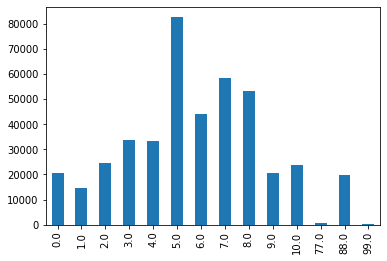

In [98]:
df.imueclt.value_counts().sort_index().plot(kind='bar')

In [99]:
df.imueclt = df.imueclt.replace({
    77.0: np.nan, 
    88.0: np.nan, 
    99.0: np.nan, 
})

<AxesSubplot:>

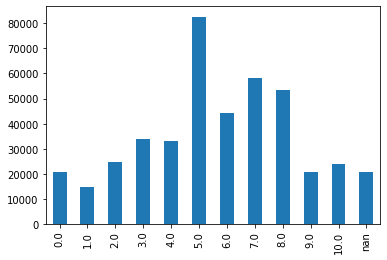

In [100]:
df.imueclt.value_counts(dropna=False).sort_index().plot(kind='bar')

In [101]:
rightDirectionCols = [
    'imsmetn', 
    'imdfetn',
    'impcntr',   
    ]
wrongDirectionCols = [
    'imbgeco',
    'imueclt',  #77 Refusal, 88 Don't know, 99 No answer
    'imwbcnt',
    ]


for col in rightDirectionCols:
    df[f'{col}_norm'] = (df[col] - df[col].mean())/df[col].std()

for col in wrongDirectionCols:
    df[f'{col}_norm'] = -(df[col] - df[col].mean())/df[col].std()

df

,imsmetn,imdfetn,impcntr,imbgeco,imueclt,imwbcnt,cntry,idno,year,anctry1,...,region,anctry1_decoded,anctry2_decoded,region_decoded,imsmetn_norm,imdfetn_norm,impcntr_norm,imbgeco_norm,imueclt_norm,imwbcnt_norm
0,4.0,3.0,3.0,4.0,9.0,7.0,AT,1.0,2002,NaN,...,NaN,None,None,NaN,1.176814,0.210653,0.131665,0.276830,-1.371959,0.117138
1,2.0,2.0,2.0,10.0,10.0,5.0,AT,2.0,2002,NaN,...,NaN,None,None,NaN,-0.271852,-0.518681,-0.575777,-0.050053,-1.758623,0.224530
2,3.0,3.0,3.0,7.0,5.0,5.0,AT,3.0,2002,NaN,...,NaN,None,None,NaN,0.452481,0.210653,0.131665,0.113389,0.174697,0.224530
3,1.0,2.0,1.0,10.0,10.0,10.0,AT,4.0,2002,NaN,...,NaN,None,None,NaN,-0.996185,-0.518681,-1.283220,-0.050053,-1.758623,-0.043951
4,8.0,8.0,8.0,88.0,NaN,88.0,AT,6.0,2002,NaN,...,NaN,None,None,NaN,4.074146,3.857324,3.668878,-4.299521,NaN,-4.232249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24623,3.0,2.0,2.0,10.0,8.0,7.0,SK,69817.0,2018,14100.0,...,SK042,Roma/Gypsy/Sinti,None,Košický kraj,0.452481,-0.518681,-0.575777,-0.050053,-0.985295,0.117138
24624,4.0,4.0,4.0,1.0,0.0,0.0,SK,69844.0,2018,14100.0,...,SK041,Roma/Gypsy/Sinti,None,Prešovský kraj,1.176814,0.939987,0.839108,0.440271,2.108017,0.493011
24625,2.0,2.0,2.0,5.0,4.0,3.0,SK,69871.0,2018,15130.0,...,SK041,Slovak nfs,None,Prešovský kraj,-0.271852,-0.518681,-0.575777,0.222349,0.561361,0.331922
24626,2.0,3.0,3.0,5.0,4.0,7.0,SK,69902.0,2018,15130.0,...,SK032,Slovak nfs,None,Banskobystrický kraj,-0.271852,0.210653,0.131665,0.222349,0.561361,0.117138


In [102]:
len(df.index.unique())

24891

In [103]:
len(df)

430870

### create indices

In [104]:
antiimmigrationCols = [
    'imsmetn_norm', 
    'imdfetn_norm',
    'impcntr_norm',   
    'imbgeco_norm',
    ]

xenophobiaCols = [
    'imueclt_norm',  
    'imwbcnt_norm',
    ]

df['index_antiimmigration'] = df[antiimmigrationCols].mean(axis=1)
df['index_xenophobia'] = df[xenophobiaCols].mean(axis=1)
df['index_all'] = df[antiimmigrationCols + xenophobiaCols].mean(axis=1)
df[['index_antiimmigration', 'index_xenophobia', 'index_all']]

,index_antiimmigration,index_xenophobia,index_all
0,0.448990,-0.627411,0.090190
1,-0.354091,-0.767047,-0.491743
2,0.227047,0.199613,0.217902
3,-0.712035,-0.901287,-0.775119
4,1.825207,-4.232249,0.613716
...,...,...,...
24623,-0.173008,-0.434079,-0.260031
24624,0.849045,1.300514,0.999534
24625,-0.285990,0.446642,-0.041780
24626,0.073204,0.339249,0.161886


In [105]:
df.to_csv('03_xenophobia/ESS/data/columnSubset_normalised_indeces.csv')

### look at spain

In [106]:
spain = df[df.cntry == 'ES']

In [107]:
len(spain)

17169

In [108]:
spain.region_decoded.value_counts(dropna=False)

NaN                           7844
Andalucía                     1862
Comunidad de Madrid           1312
Cataluña                      1268
Comunidad Valenciana           924
Galicia                        622
Castilla y León                544
Castilla-La Mancha             448
País Vasco                     427
Canarias                       354
Aragón                         308
Extremadura                    252
Región de Murcia               248
Principado de Asturias         228
Illes Balears                  180
Cantabria                      130
Comunidad Foral de Navarra     126
La Rioja                        58
Ciudad Autónoma de Ceuta        21
Ciudad Autónoma de Melilla      13
Name: region_decoded, dtype: int64

In [109]:
spain.region_decoded.isna().value_counts()

False    9325
True     7844
Name: region_decoded, dtype: int64

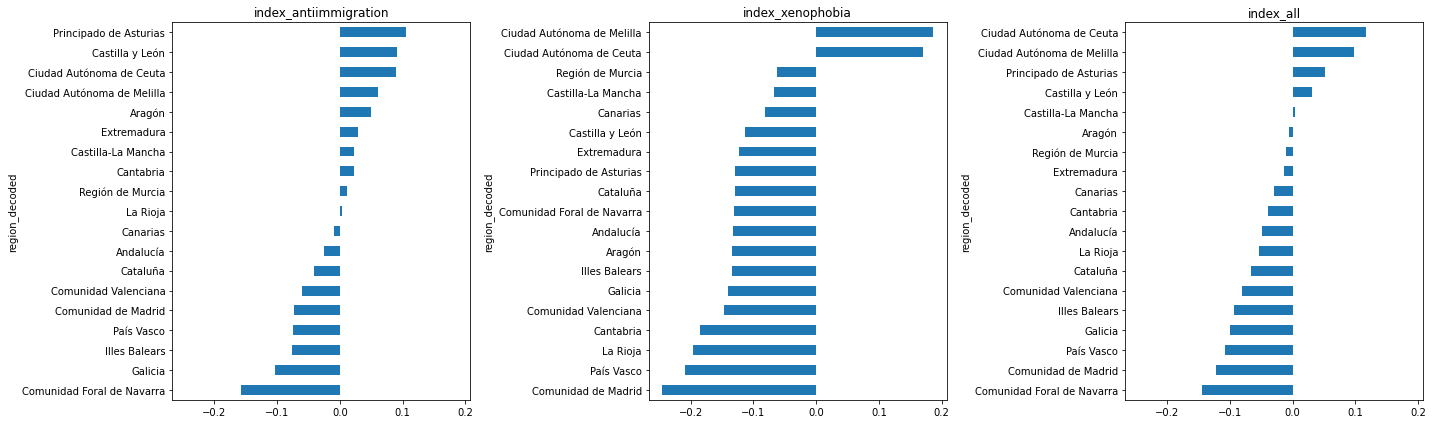

In [110]:
indeces = ['index_antiimmigration', 'index_xenophobia', 'index_all']

fig, axes = plt.subplots(
    nrows=1, 
    ncols=3, 
    figsize=(20, 6), 
    sharex=True
    )

for i, indexName in enumerate(indeces):

    (
        spain
        .groupby('region_decoded')
        [indexName]
        .mean()
        .sort_values()
        .plot(
            kind='barh', 
            title=indexName,
            ax=axes[i],
            )
        )

plt.tight_layout()
plt.savefig('03_xenophobia/indeces.png')
plt.show()